# Scanpy analysis PBMC 4k cells
Profiling Scanpy for PBMC 4K cell, data download from 10X genomic website

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.2.2 anndata==0.6.4 numpy==1.13.3 scipy==1.0.0 pandas==0.21.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
results_file='/Users/jishuxu/Documents/datasets/pbmc4k/pbmc4k_results.h5ad'
path= '/Users/jishuxu/Documents/datasets/pbmc4k/filtered_gene_bc_matrices/GRCh38/'
d = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
d.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
d.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
d.shape
d.write(results_file)

... reading from cache file ./cache/Users-jishuxu-Documents-datasets-pbmc4k-filtered_gene_bc_matrices-GRCh38-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Check out row names or gene names

In [3]:
d.var_names_make_unique()

In [4]:
d.var.head(5)

""
RP11-34P13.3
FAM138A
OR4F5
RP11-34P13.7
RP11-34P13.8


# Data Processing

## Filtering

We will do some basic filtering on cells and genes. For example, we will filter out cells with less 200 genes expressed and filter out cells which expressed in less 200 cells

In [5]:
sc.pp.filter_cells(d, min_genes=200)
sc.pp.filter_genes(d, min_cells=200)

In [6]:
d.shape

(4340, 6522)

## mito- QC 

We also need to run some QC analysis. Here we would like to know what % of mito- genes expressed among cells.

In [7]:
mito_genes = [name for name in d.var_names if name.startswith('MT-')]
mito_genes

['MT-ND1',
 'MT-ND2',
 'MT-CO1',
 'MT-CO2',
 'MT-ATP8',
 'MT-ATP6',
 'MT-CO3',
 'MT-ND3',
 'MT-ND4L',
 'MT-ND4',
 'MT-ND5',
 'MT-ND6',
 'MT-CYB']

In [8]:
d.obs['percent_mito'] = np.sum(
    d[:, mito_genes].X, axis=1)/ np.sum(d.X, axis=1)

In [9]:
d.obs.head(5)

,n_genes,percent_mito
0,,
AAACCTGAGAAGGCCT-1,748,0.065875
AAACCTGAGACAGACC-1,1052,0.056066
AAACCTGAGATAGTCA-1,739,0.075061
AAACCTGAGCGCCTCA-1,875,0.039433
AAACCTGAGGCATGGT-1,951,0.023088


## UMI/Reads Counts QC

Calculate total reads counts/UMI counts of each cell

In [10]:
d.obs['n_counts'] = d.X.sum(axis=1)

In [11]:
d.obs.head(5)

,n_genes,percent_mito,n_counts
0,,,
AAACCTGAGAAGGCCT-1,748,0.065875,1685.0
AAACCTGAGACAGACC-1,1052,0.056066,3157.0
AAACCTGAGATAGTCA-1,739,0.075061,1652.0
AAACCTGAGCGCCTCA-1,875,0.039433,2257.0
AAACCTGAGGCATGGT-1,951,0.023088,2902.0


## Visualization of QCs

First we plot violin plots of each QC metrics and then plot scatterplot between QC metrics

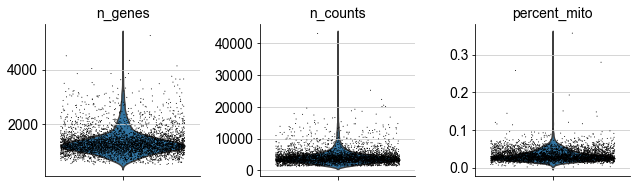

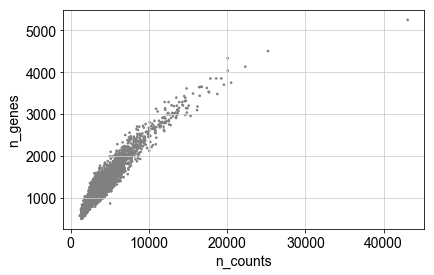

In [12]:
sc.pl.violin(d, ['n_genes', 'n_counts','percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(d, x='n_counts', y='n_genes')

## Filter cells again

In [13]:
d = d[d.obs['n_genes'] < 2500, :]
d = d[d.obs['percent_mito'] < 0.05, :]

In [14]:
d.shape

(3656, 6522)

## Log- expression

Take logorithm of  raw gene expression for later use in differential testing and visualizations of gene expression. Make a copy to reserve the raw data.

In [15]:
d.raw = sc.pp.log1p(d, copy=True)


In [16]:
d.filtered=d.copy

## Normalization

Let's normalize by cell. 

In [17]:
sc.pp.normalize_per_cell(d,counts_per_cell_after=1e4)  # need to redo normalization after filtering

In [18]:
d.shape

(3656, 6522)

## Identify highly-variable genes.

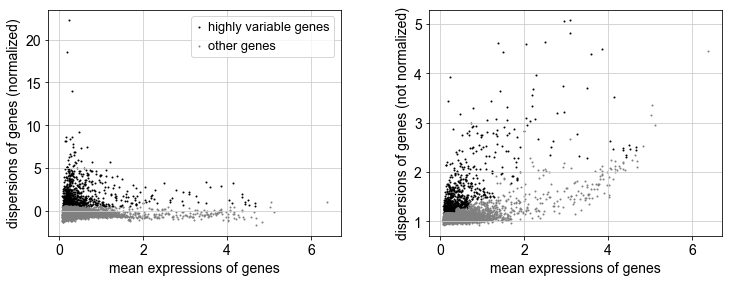

(3656, 903)

In [19]:
filter_result = sc.pp.filter_genes_dispersion(
    d.X, min_mean=0.0125, max_mean=5, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)
d = d[:,filter_result.gene_subset]
d.shape

## Run PCA

In [20]:
sc.pp.normalize_per_cell(d) # re-normalize after filtering
sc.pp.log1p(d) 
sc.pp.scale(d, max_value=10)
sc.tl.pca(d, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 0.39 GB, difference +0.39 GB


In [21]:
d.shape

(3656, 903)

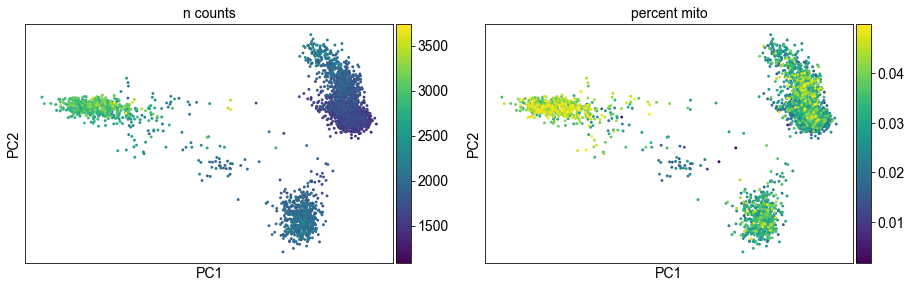

In [22]:
d.obsm['X_pca'] *= -1  
sc.pl.pca_scatter(d, color=['n_counts', 'percent_mito'])

plot PCA results

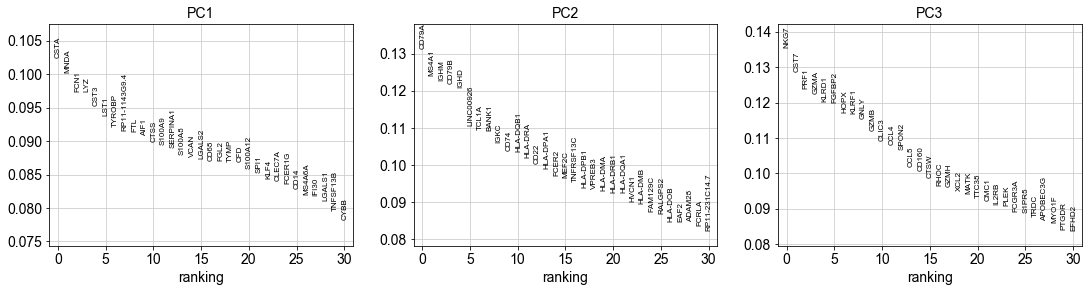

In [23]:
sc.pl.pca_loadings(d)

# Constructing and visualizing the single-cell graph

This will construct the single-cell graph - usually a knn graph - that describes cells in their relation to their neighbors. tSNE and umap are computed. 

In [24]:
%%time
sc.pp.neighbors(d)
sc.logging.print_memory_usage()

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04.56) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Memory usage: current 0.29 GB, difference -0.02 GB
CPU times: user 4.22 s, sys: 897 ms, total: 5.12 s
Wall time: 4.57 s


In [25]:
%%time
sc.tl.umap(d)
sc.logging.print_memory_usage()

computing UMAP
    finished (0:00:06.56) --> added
    'X_umap', UMAP coordinates (adata.obsm)
Memory usage: current 0.29 GB, difference +0.01 GB
CPU times: user 6.53 s, sys: 48 ms, total: 6.58 s
Wall time: 6.57 s


Visualize in umap and tsen

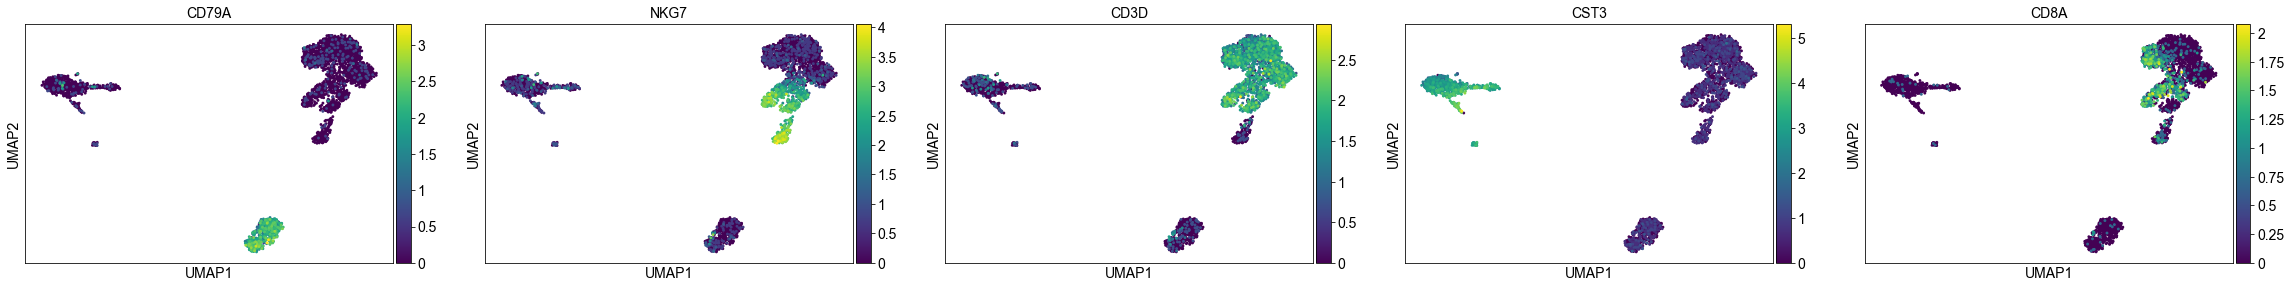

In [26]:
sc.pl.umap(d,color=["CD79A","NKG7","CD3D","CST3","CD8A"])

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:01:22.10) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
Memory usage: current 0.31 GB, difference +0.01 GB


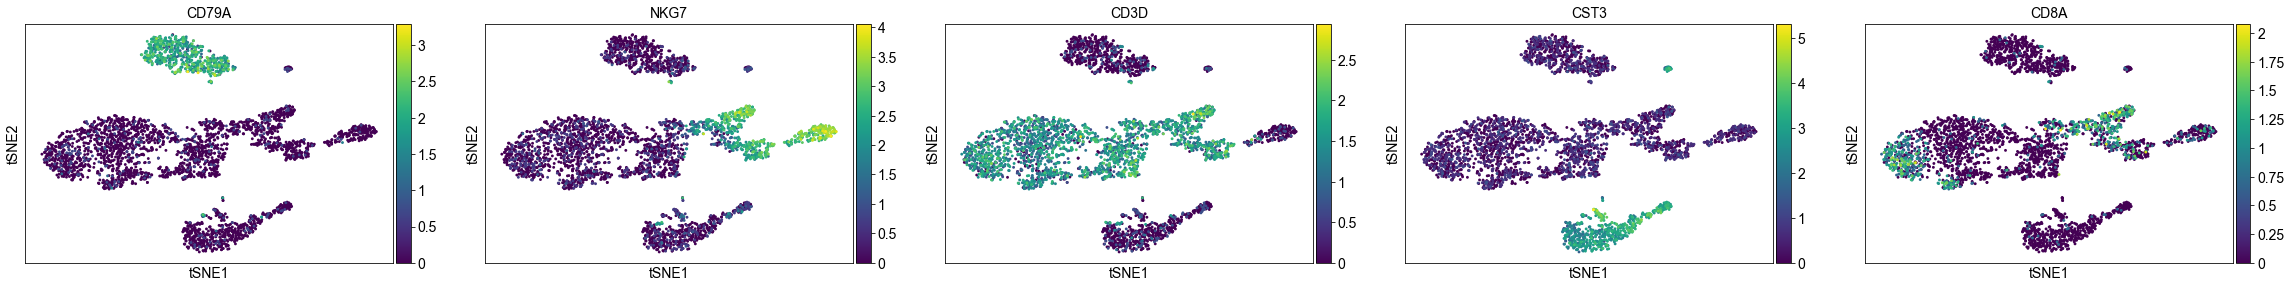

In [27]:
sc.tl.tsne(d, random_state=2, n_pcs=10)
sc.logging.print_memory_usage()
sc.pl.tsne(d, color=["CD79A","NKG7","CD3D","CST3","CD8A"])
d.write(results_file)

# Clustering the single-cell graph

we use the Louvain algorithm for single-cell analysis.

In [28]:
sc.tl.louvain(d, resolution=0.3)
sc.logging.print_memory_usage()

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.27) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Memory usage: current 0.33 GB, difference +0.00 GB


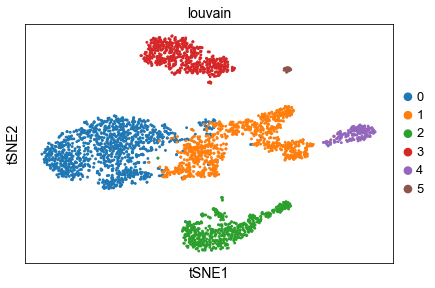

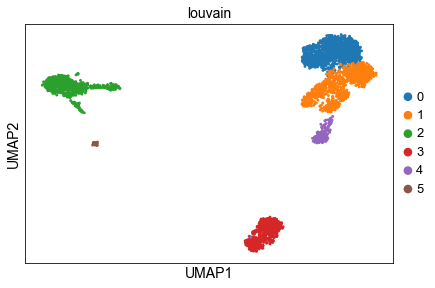

In [29]:
sc.pl.tsne(d, color='louvain')
sc.pl.umap(d, color='louvain')

In [30]:
d.write(results_file)

# Marker Genes

## Marker Genes(raw data)

By default, scanpy will use .raw data to rank gene. 

ranking genes
    finished (0:00:01.06) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain.pdf


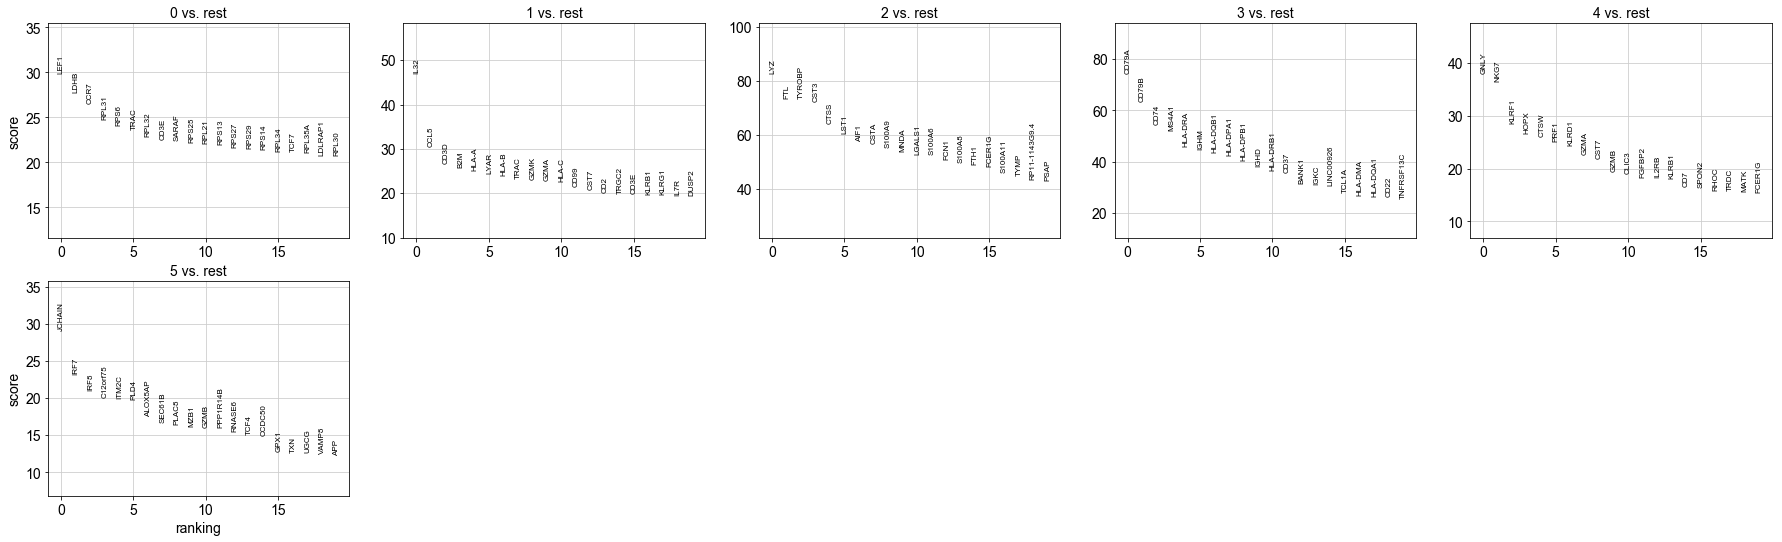

In [31]:
sc.tl.rank_genes_groups(d, 'louvain')
sc.pl.rank_genes_groups(d, n_genes=20, save='.pdf')

We rank genes using logistic regression.

ranking genes
    finished (0:00:03.92)


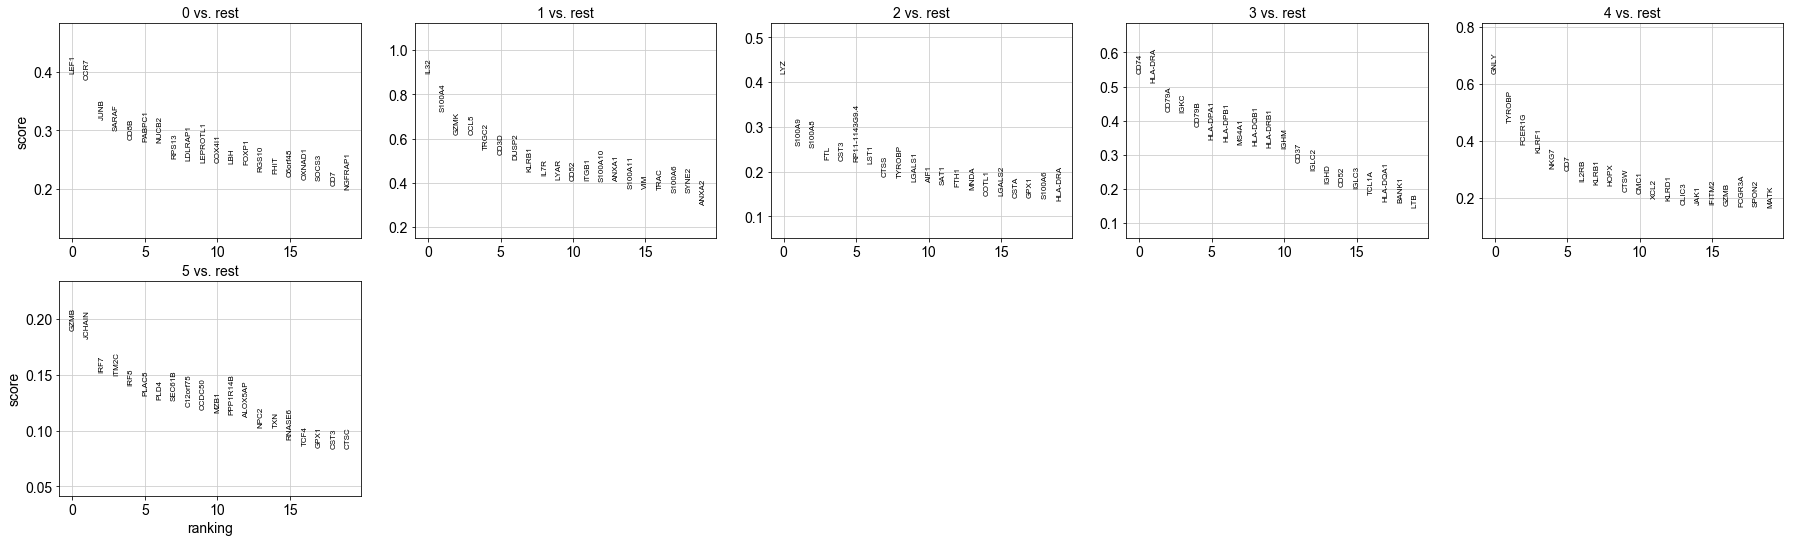

In [32]:
sc.settings.verbosity = 2  # reduce the verbosity to no longer see hints
sc.tl.rank_genes_groups(d, 'louvain', method='logreg')
sc.pl.rank_genes_groups(d, n_genes=20)

Show the 10 top ranked genes per cluster 0, 1, ..., in a dataframe.

In [33]:
pd.DataFrame(d.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5
0,LEF1,IL32,LYZ,CD74,GNLY,GZMB
1,CCR7,S100A4,S100A9,HLA-DRA,TYROBP,JCHAIN
2,JUNB,GZMK,S100A8,CD79A,FCER1G,IRF7
3,SARAF,CCL5,FTL,IGKC,KLRF1,ITM2C
4,CD8B,TRGC2,CST3,CD79B,NKG7,IRF8
5,PABPC1,CD3D,RP11-1143G9.4,HLA-DPA1,CD7,PLAC8
6,NUCB2,DUSP2,LST1,HLA-DPB1,IL2RB,PLD4
7,RPS13,KLRB1,CTSS,MS4A1,KLRB1,SEC61B
8,LDLRAP1,IL7R,TYROBP,HLA-DQB1,HOPX,C12orf75
9,LEPROTL1,LYAR,LGALS1,HLA-DRB1,CTSW,CCDC50


Get a table with scores and groups.

In [34]:
result = d.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(10)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s
0,LEF1,0.398114,IL32,0.896682,LYZ,0.420561,CD74,0.539792,GNLY,0.638278,GZMB,0.189506
1,CCR7,0.386599,S100A4,0.722965,S100A9,0.260060,HLA-DRA,0.512206,TYROBP,0.465468,JCHAIN,0.182903
2,JUNB,0.319400,GZMK,0.620614,S100A8,0.254080,CD79A,0.427231,FCER1G,0.388803,IRF7,0.152561
3,SARAF,0.300854,CCL5,0.618943,FTL,0.228248,IGKC,0.423904,KLRF1,0.359320,ITM2C,0.149102
4,CD8B,0.284547,TRGC2,0.551089,CST3,0.226033,CD79B,0.383342,NKG7,0.301680,IRF8,0.140796
5,PABPC1,0.282152,CD3D,0.529346,RP11-1143G9.4,0.223669,HLA-DPA1,0.344985,CD7,0.296389,PLAC8,0.131440
6,NUCB2,0.279614,DUSP2,0.504571,LST1,0.218462,HLA-DPB1,0.338740,IL2RB,0.257567,PLD4,0.128362
7,RPS13,0.251835,KLRB1,0.452238,CTSS,0.189259,MS4A1,0.331810,KLRB1,0.247543,SEC61B,0.126943
8,LDLRAP1,0.248373,IL7R,0.433116,TYROBP,0.188324,HLA-DQB1,0.328907,HOPX,0.244670,C12orf75,0.121611
9,LEPROTL1,0.246173,LYAR,0.416162,LGALS1,0.177468,HLA-DRB1,0.322990,CTSW,0.222646,CCDC50,0.118811


Compare to two clusters

ranking genes
    finished (0:00:00.16)


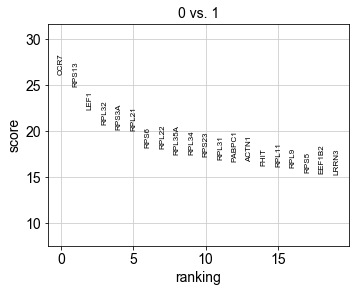

In [35]:
sc.tl.rank_genes_groups(d, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(d, groups=['0'], n_genes=20)

## Marker Genes(normalized data)

we can remove .raw data and repeat analysis by uding normalized data

In [36]:
d.raw=None

ranking genes
    finished (0:00:00.10)
saving figure to file ./figures/rank_genes_groups_louvain.pdf


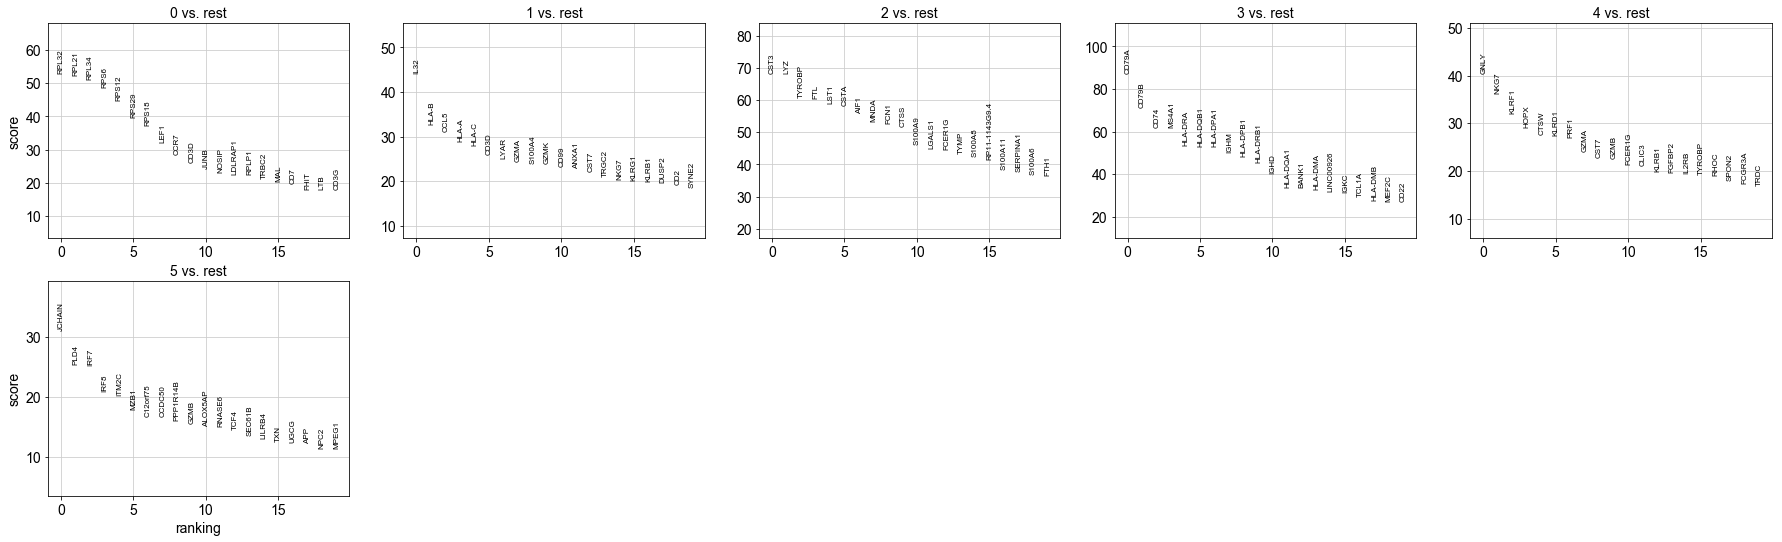

In [37]:
sc.tl.rank_genes_groups(d, 'louvain')
sc.pl.rank_genes_groups(d, n_genes=20, save='.pdf')

ranking genes
    finished (0:00:05.25)


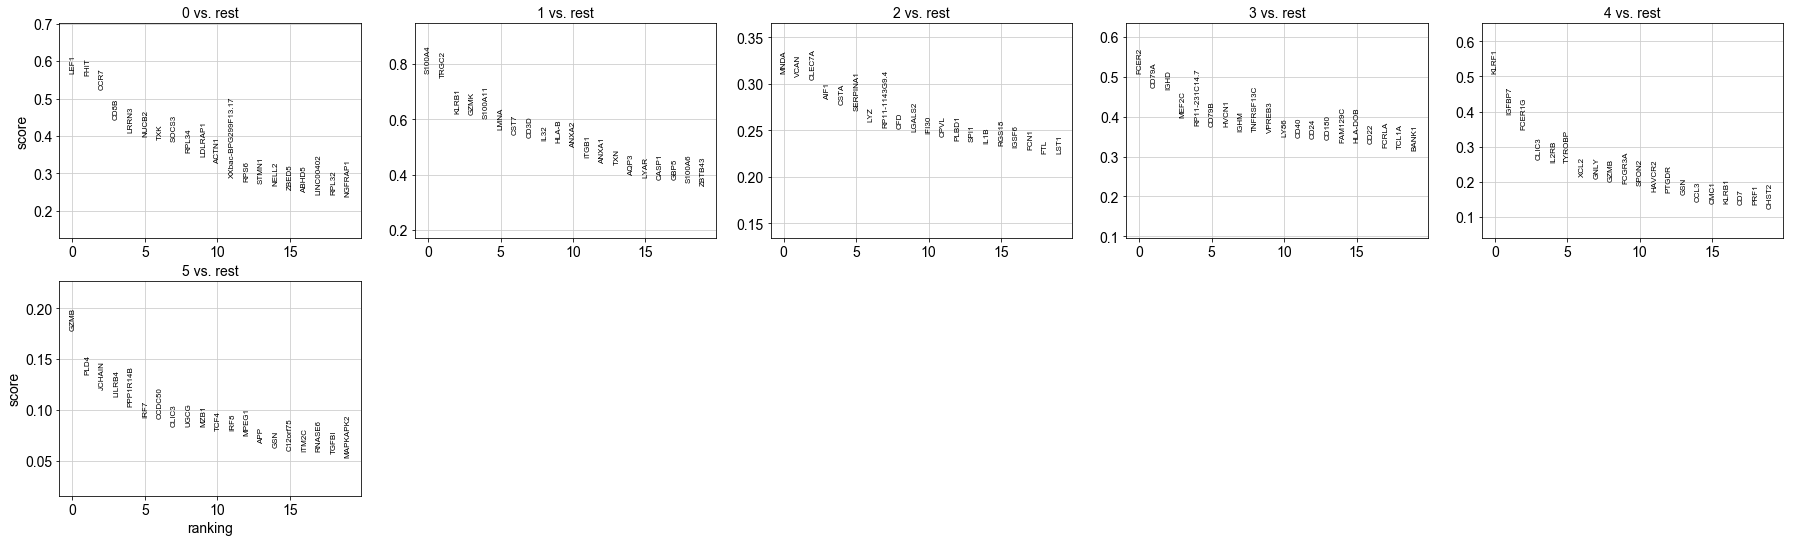

In [38]:
sc.settings.verbosity = 2  # reduce the verbosity to no longer see hints
sc.tl.rank_genes_groups(d, 'louvain', method='logreg')
sc.pl.rank_genes_groups(d, n_genes=20)

We rank genes using logistic regression.

Show the 10 top ranked genes per cluster 0, 1, ..., in a dataframe.

In [39]:
pd.DataFrame(d.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5
0,LEF1,S100A4,MNDA,FCER2,KLRF1,GZMB
1,FHIT,TRGC2,VCAN,CD79A,IGFBP7,PLD4
2,CCR7,KLRB1,CLEC7A,IGHD,FCER1G,JCHAIN
3,CD8B,GZMK,AIF1,MEF2C,CLIC3,LILRB4
4,LRRN3,S100A11,CSTA,RP11-231C14.7,IL2RB,PPP1R14B
5,NUCB2,LMNA,SERPINA1,CD79B,TYROBP,IRF7
6,TXK,CST7,LYZ,HVCN1,XCL2,CCDC50
7,SOCS3,CD3D,RP11-1143G9.4,IGHM,GNLY,CLIC3
8,RPL34,IL32,CFD,TNFRSF13C,GZMB,UGCG
9,LDLRAP1,HLA-B,LGALS2,VPREB3,FCGR3A,MZB1


In [40]:
result = d.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(10)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s
0,LEF1,0.568128,S100A4,0.768267,MNDA,0.311602,FCER2,0.509071,KLRF1,0.509811,GZMB,0.178074
1,FHIT,0.563427,TRGC2,0.751680,VCAN,0.307693,CD79A,0.473161,IGFBP7,0.390758,PLD4,0.135277
2,CCR7,0.525526,KLRB1,0.623172,CLEC7A,0.305313,IGHD,0.468469,FCER1G,0.350706,JCHAIN,0.120390
3,CD8B,0.445363,GZMK,0.617638,AIF1,0.283326,MEF2C,0.397801,CLIC3,0.264263,LILRB4,0.113947
4,LRRN3,0.410025,S100A11,0.604061,CSTA,0.278475,RP11-231C14.7,0.378324,IL2RB,0.254560,PPP1R14B,0.103928
5,NUCB2,0.398595,LMNA,0.563030,SERPINA1,0.272081,CD79B,0.376691,TYROBP,0.254129,IRF7,0.093316
6,TXK,0.390986,CST7,0.544917,LYZ,0.259428,HVCN1,0.375863,XCL2,0.214791,CCDC50,0.092231
7,SOCS3,0.386169,CD3D,0.536497,RP11-1143G9.4,0.253733,IGHM,0.364240,GNLY,0.210276,CLIC3,0.083978
8,RPL34,0.355821,IL32,0.523597,CFD,0.251847,TNFRSF13C,0.363198,GZMB,0.202126,UGCG,0.083857
9,LDLRAP1,0.345846,HLA-B,0.518773,LGALS2,0.248751,VPREB3,0.360941,FCGR3A,0.194193,MZB1,0.083767


ranking genes
    finished (0:00:00.01)


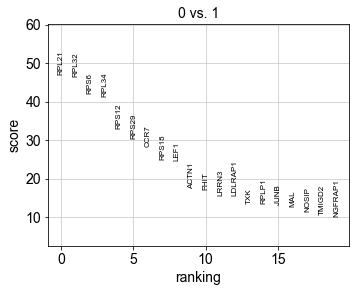

In [41]:
sc.tl.rank_genes_groups(d, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(d, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin 

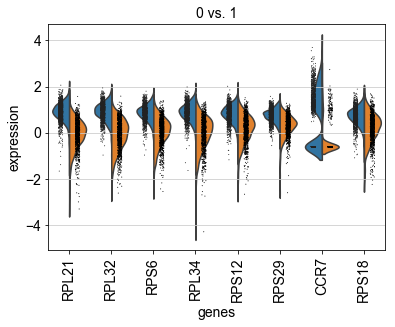

In [42]:
sc.pl.rank_genes_groups_violin(d, groups='0', n_genes=8)

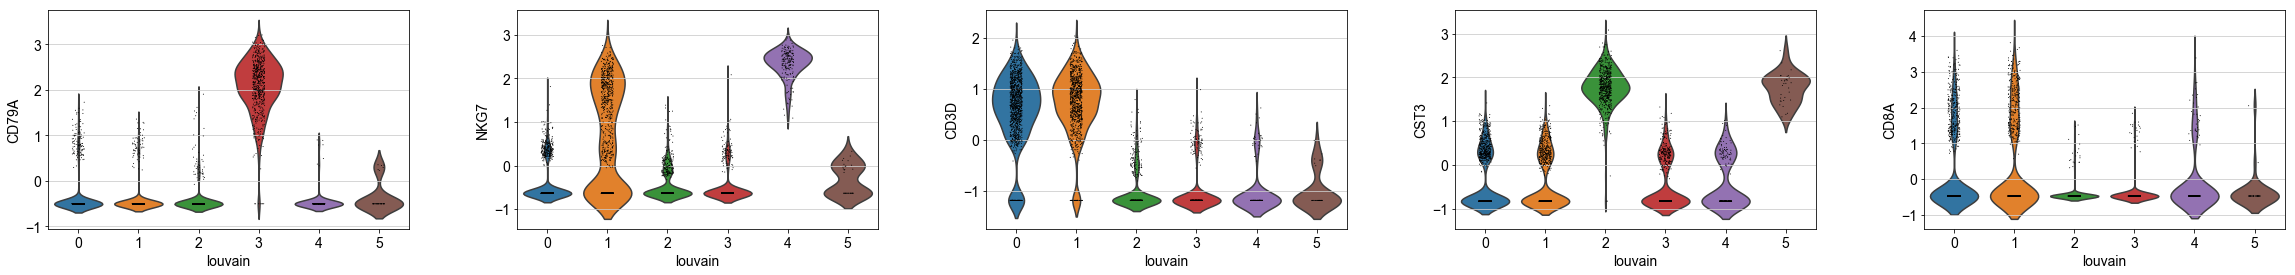

In [44]:
sc.pl.violin(d, ["CD79A","NKG7","CD3D","CST3","CD8A"], groupby='louvain')